<a href="https://colab.research.google.com/github/Xiw2000/2022Spring/blob/main/Shen_original.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Salmonella and E. faceium data on chicken

### Data input

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.linear_model import BayesianRidge
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from matplotlib import cm
from sklearn.model_selection import GridSearchCV
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV

In [2]:
data = pd.read_excel('/content/Raw Data_v2.xlsx')
print(data.head())

    Bacterial  Salt_Concentration  Temperature  Time  Population
0  Salmonella                   0           62     0        6.72
1  Salmonella                   0           62     0        6.68
2  Salmonella                   0           62     0        6.75
3  Salmonella                   0           62     0        6.66
4  Salmonella                   0           62     0        6.68


### Encode Categorical Variables

In [3]:
# Map Bacterial column to numeric values
data['Bacterial'] = data['Bacterial'].map({'E Faecium': 0, 'Salmonella': 1})

In [4]:
X = data[['Bacterial', 'Salt_Concentration', 'Temperature', 'Time']]
y = data['Population']

### Split Data into Training and Testing Sets

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Standardize Features

In [6]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### RF regression (default parameters)

In [7]:
rf_regressor = RandomForestRegressor(random_state=42)
rf_cv_scores = cross_val_score(rf_regressor, X_train, y_train, cv=10, scoring='r2')
print(f"Mean Cross Validation R^2 Score for Random Forest: {np.mean(rf_cv_scores):.4f}")

# Fit the model on the entire training data
rf_regressor.fit(X_train, y_train)

# Predictions on test set
rf_preds = rf_regressor.predict(X_test)

# Evaluate performance
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_preds))
rf_r2 = r2_score(y_test, rf_preds)
print(f"Test dataset RMSE: {rf_rmse:.4f}, R^2 Score: {rf_r2:.4f}")

Mean Cross Validation R^2 Score for Random Forest: 0.9301
Test dataset RMSE: 0.4198, R^2 Score: 0.9363


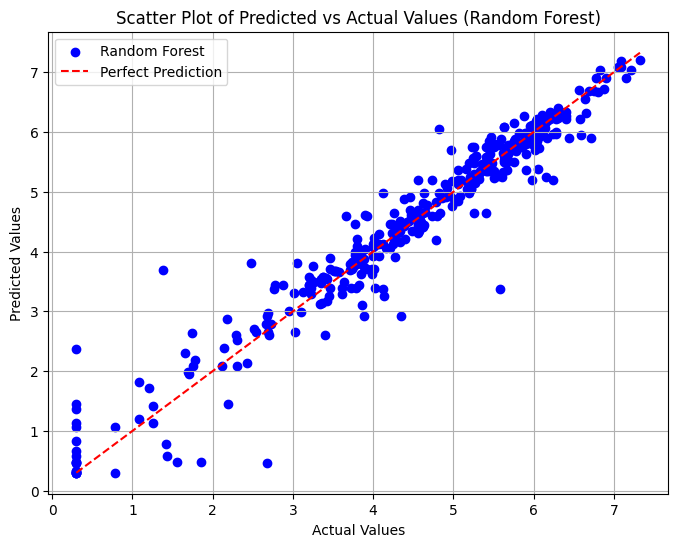

In [8]:
# Scatter plot for Random Forest
plt.figure(figsize=(8, 6))
plt.scatter(y_test, rf_preds, color='blue', label='Random Forest')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red', label='Perfect Prediction')
plt.title('Scatter Plot of Predicted vs Actual Values (Random Forest)')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.grid(True)
plt.show()

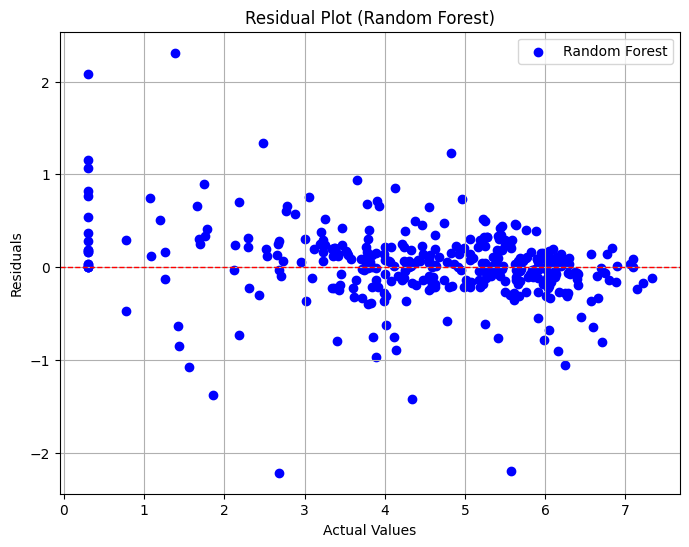

In [9]:
# Residual plot for Random Forest
plt.figure(figsize=(8, 6))
plt.scatter(y_test, rf_preds - y_test, color='blue', label='Random Forest')
plt.axhline(y=0, color='red', linestyle='--', linewidth=1)
plt.title('Residual Plot (Random Forest)')
plt.xlabel('Actual Values')
plt.ylabel('Residuals')
plt.legend()
plt.grid(True)
plt.show()

Feature importance

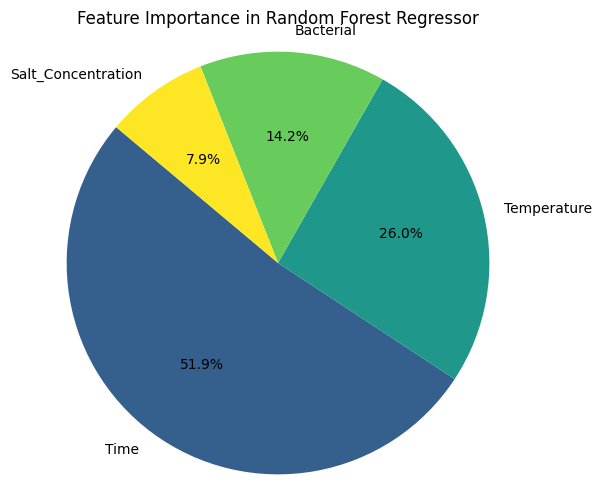

In [10]:
importances = rf_regressor.feature_importances_
feature_names = X.columns

importances_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importances_df = importances_df.sort_values(by='Importance', ascending=False)

colors = cm.viridis(np.linspace(0.3, 1, len(importances_df)))
plt.figure(figsize=(6, 6))
plt.pie(importances_df['Importance'], labels=importances_df['Feature'], autopct='%1.1f%%', startangle=140, colors=colors)
plt.title('Feature Importance in Random Forest Regressor')
plt.axis('equal')
plt.show()

### RF regression (tunning hyperparameters)
The best hyperparameters in a GridSearchCV process are chosen based on the cross-validation score for each parameter combination across the training dataset. GridSearchCV generates all possible combinations of hyperparameters specified in the rf_params. For each parameter combination, GridSearchCV computes the mean R² score across all 10 folds. This score provides an estimate of how well this specific combination of hyperparameters performs in a general setting.

In [11]:
rf_regressor = RandomForestRegressor(random_state=42)

from sklearn.model_selection import GridSearchCV

rf_params = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]
}
rf_grid_search = HalvingGridSearchCV(rf_regressor, rf_params, cv=10, scoring='r2', verbose=3)
rf_grid_search.fit(X_train, y_train)
best_rf_model = rf_grid_search.best_estimator_

Streaming output truncated to the last 5000 lines.
[CV 6/10] END max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=200;, score=(train=0.239, test=-0.168) total time=   0.4s
[CV 7/10] END max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=200;, score=(train=0.466, test=-6.183) total time=   0.4s
[CV 8/10] END max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=200;, score=(train=0.286, test=-29.409) total time=   0.4s
[CV 9/10] END max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=200;, score=(train=0.163, test=0.220) total time=   0.4s
[CV 10/10] END max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=200;, score=(train=0.394, test=-104.306) total time=   0.4s
[CV 1/10] END max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=300;, score=(train=0.291, test=-27.376) tota

### The best hyperparameters

In [12]:
print("Best Hyperparameters:", rf_grid_search.best_params_)

Best Hyperparameters: {'max_depth': None, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


### Model validation

In [13]:
# Make predictions on the test set with the best model from GridSearchCV
rf_test_preds = best_rf_model.predict(X_test)

# Calculate performance metrics
rf_test_rmse = np.sqrt(mean_squared_error(y_test, rf_test_preds))
rf_test_r2 = r2_score(y_test, rf_test_preds)
print(f"Optimized Random Forest - Root Mean Squared Error: {rf_test_rmse:.4f}, R^2 Score: {rf_test_r2:.4f}")

Optimized Random Forest - Root Mean Squared Error: 0.4216, R^2 Score: 0.9358


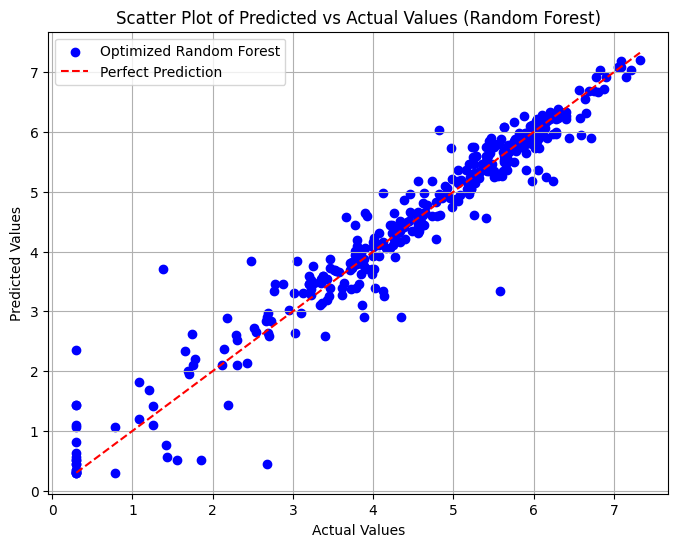

In [14]:
# Scatter plot for Random Forest after tunning the hyperparameters
plt.figure(figsize=(8, 6))
plt.scatter(y_test, rf_test_preds, color='blue', label='Optimized Random Forest')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red', label='Perfect Prediction')
plt.title('Scatter Plot of Predicted vs Actual Values (Random Forest)')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.grid(True)
plt.show()

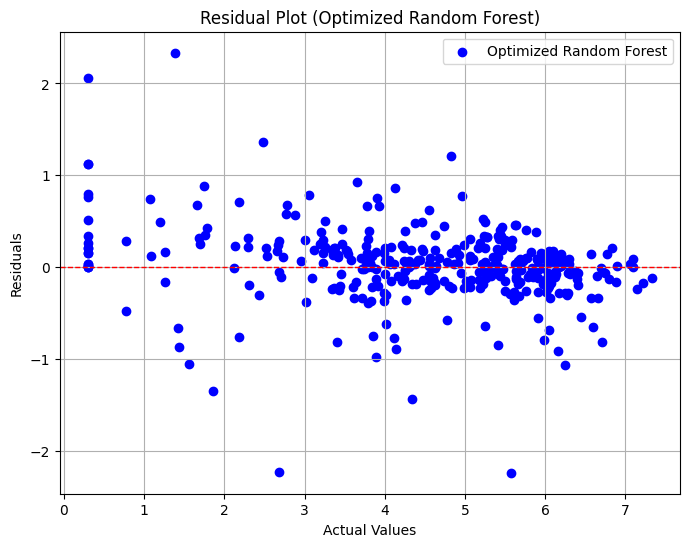

In [15]:
# Residual Plot
plt.figure(figsize=(8, 6))
plt.scatter(y_test, rf_test_preds - y_test, color='blue', label='Optimized Random Forest')
plt.axhline(y=0, color='red', linestyle='--', linewidth=1)
plt.title('Residual Plot (Optimized Random Forest)')
plt.xlabel('Actual Values')
plt.ylabel('Residuals')
plt.legend()
plt.grid(True)
plt.show()

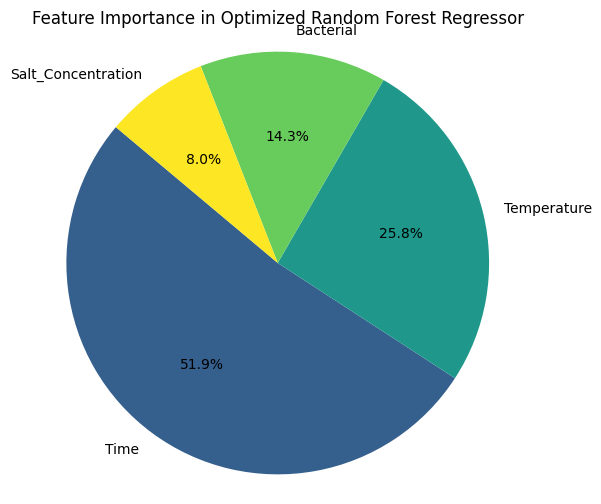

In [16]:
# Feature Importance Plot
importances = best_rf_model.feature_importances_
feature_names = X.columns

importances_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importances_df = importances_df.sort_values(by='Importance', ascending=False)

colors = plt.cm.viridis(np.linspace(0.3, 1, len(importances_df)))
plt.figure(figsize=(6, 6))
plt.pie(importances_df['Importance'], labels=importances_df['Feature'], autopct='%1.1f%%', startangle=140, colors=colors)
plt.title('Feature Importance in Optimized Random Forest Regressor')
plt.axis('equal')
plt.show()

### Support Vector Regression (SVR) (default parameters)

In [17]:
from sklearn.svm import SVR
from sklearn.inspection import permutation_importance

svr_regressor = SVR()
svr_cv_scores = cross_val_score(svr_regressor, X_train_scaled, y_train, cv=10, scoring='r2')
print(f"Mean Cross-Validation R^2 Score: {np.mean(svr_cv_scores):.4f}")


svr_regressor.fit(X_train_scaled, y_train)

svr_preds = svr_regressor.predict(X_test_scaled)
svr_rmse = np.sqrt(mean_squared_error(y_test, svr_preds))
svr_r2 = r2_score(y_test, svr_preds)
print(f"Test dataset RMSE:{svr_rmse:.4f}, R^2 Score: {svr_r2:.4f}")

Mean Cross-Validation R^2 Score: 0.9047
Test dataset RMSE:0.5070, R^2 Score: 0.9071


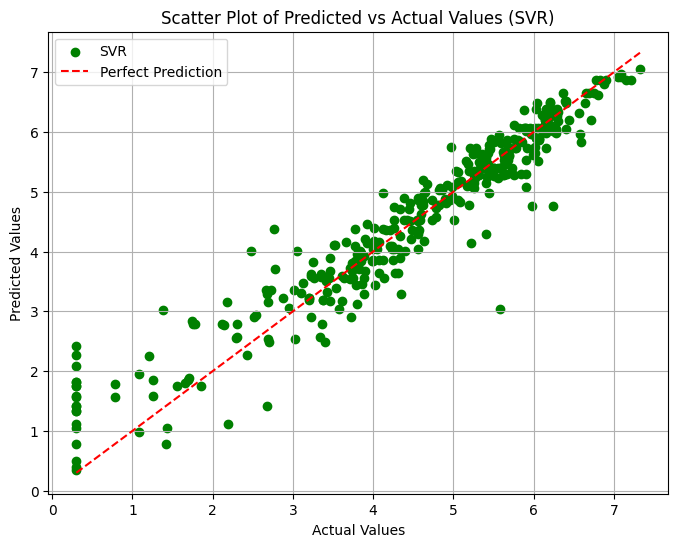

In [18]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, svr_preds, color='green', label='SVR')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red', label='Perfect Prediction')
plt.title('Scatter Plot of Predicted vs Actual Values (SVR)')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.grid(True)
plt.show()

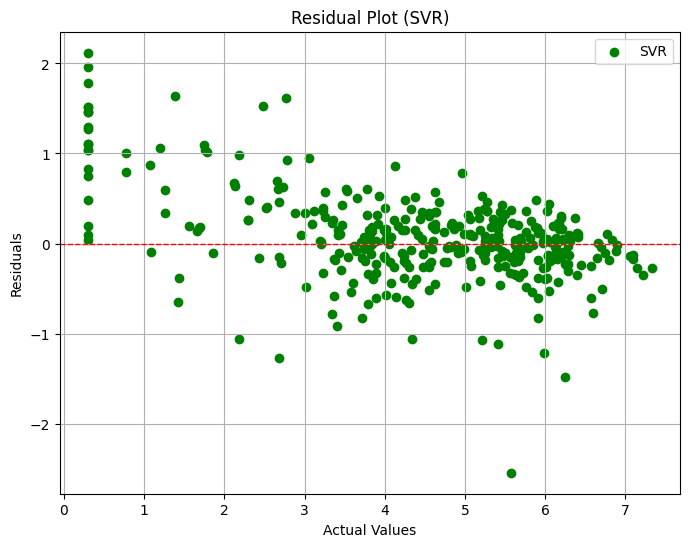

In [19]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, svr_preds - y_test, color='green', label='SVR')
plt.axhline(y=0, color='red', linestyle='--', linewidth=1)
plt.title('Residual Plot (SVR)')
plt.xlabel('Actual Values')
plt.ylabel('Residuals')
plt.legend()
plt.grid(True)
plt.show()

Feature importance

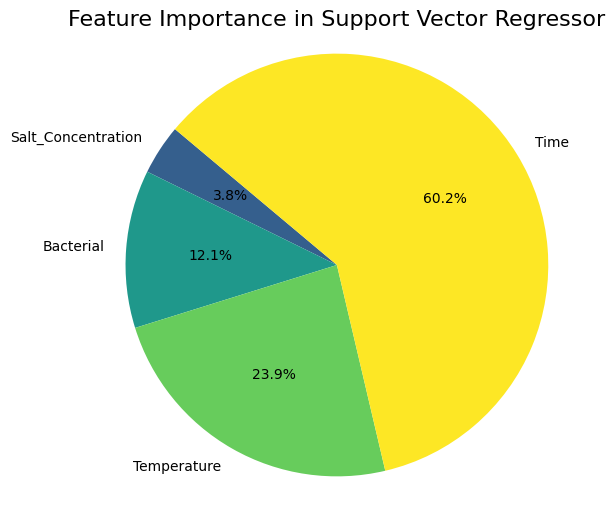

In [20]:
perm_importance = permutation_importance(svr_regressor, X_test_scaled, y_test, n_repeats=10, random_state=42)
sorted_idx = perm_importance.importances_mean.argsort()
sorted_features = X.columns[sorted_idx]
sorted_importances = perm_importance.importances_mean[sorted_idx]

plt.figure(figsize=(6, 6))
plt.pie(sorted_importances, labels=sorted_features, autopct='%1.1f%%', startangle=140, colors=colors)
plt.title('Feature Importance in Support Vector Regressor', fontsize=16)
plt.axis('equal')
plt.show()

### SVR (Tuning hyperparameter)

In [21]:
svr_regressor = SVR()

svr_params = {
    'kernel': ['linear', 'rbf'],
    'C': [0.1, 1, 10, 100],
    'epsilon': [0.01, 0.1, 0.5, 1],
    'gamma': ['scale', 'auto']  # for 'rbf', 'poly', 'sigmoid' kernels
}

svr_grid_search = HalvingGridSearchCV(svr_regressor, svr_params, cv=10, scoring='r2', verbose=3)

# Fit the model
svr_grid_search.fit(X_train_scaled, y_train)

# Get the best model
best_svr_model = svr_grid_search.best_estimator_
print("Best SVR Hyperparameters:", svr_grid_search.best_params_)

n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 54
max_resources_: 1460
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 64
n_resources: 54
Fitting 10 folds for each of 64 candidates, totalling 640 fits
[CV 1/10] END C=0.1, epsilon=0.01, gamma=scale, kernel=linear;, score=(train=0.430, test=-4.044) total time=   0.0s
[CV 2/10] END C=0.1, epsilon=0.01, gamma=scale, kernel=linear;, score=(train=0.531, test=0.512) total time=   0.0s
[CV 3/10] END C=0.1, epsilon=0.01, gamma=scale, kernel=linear;, score=(train=0.490, test=0.119) total time=   0.0s
[CV 4/10] END C=0.1, epsilon=0.01, gamma=scale, kernel=linear;, score=(train=0.522, test=0.711) total time=   0.0s
[CV 5/10] END C=0.1, epsilon=0.01, gamma=scale, kernel=linear;, score=(train=0.683, test=0.402) total time=   0.0s
[CV 6/10] END C=0.1, epsilon=0.01, gamma=scale, kernel=linear;, score=(train=0.392, test=-0.103) total time=   0.0s
[CV 7/10] END C=0.1, epsilon=0.01, gamma=scale,

In [22]:
print("Best Hyperparameters:", svr_grid_search.best_params_)

Best Hyperparameters: {'C': 10, 'epsilon': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}


In [23]:
# Make predictions on the test set with the best model from GridSearchCV
svr_test_preds = best_svr_model.predict(X_test_scaled)

# Calculate performance metrics
svr_test_rmse = np.sqrt(mean_squared_error(y_test, svr_test_preds))
svr_test_r2 = r2_score(y_test, svr_test_preds)
print(f"Optimized SVR - Root Mean Squared Error: {svr_test_rmse:.4f}, R^2 Score: {svr_test_r2:.4f}")

Optimized SVR - Root Mean Squared Error: 0.4501, R^2 Score: 0.9268


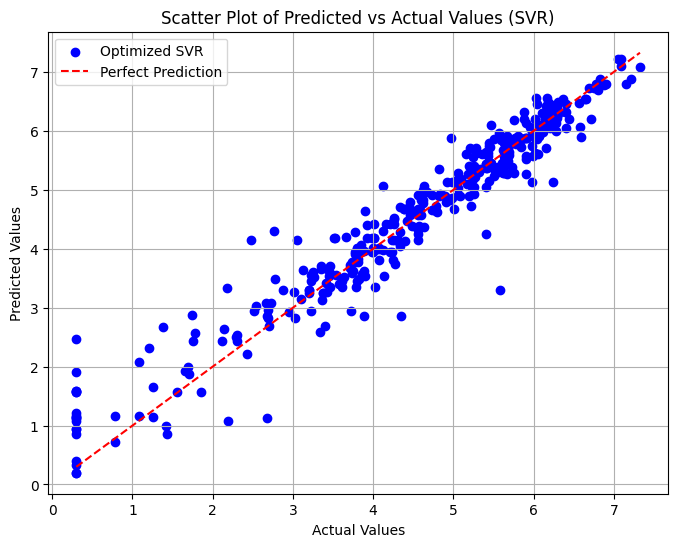

In [24]:
# Scatter plot for SVR after tunning the hyperparameters
plt.figure(figsize=(8, 6))
plt.scatter(y_test, svr_test_preds, color='blue', label='Optimized SVR')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red', label='Perfect Prediction')
plt.title('Scatter Plot of Predicted vs Actual Values (SVR)')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.grid(True)
plt.show()

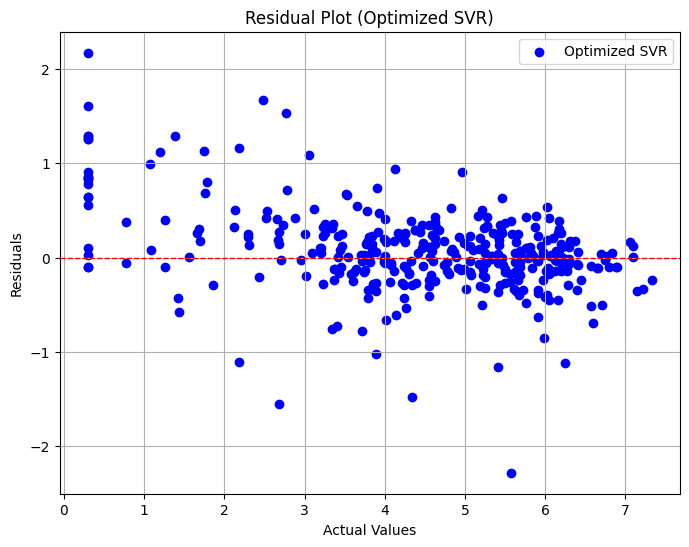

In [25]:
# Residual Plot
plt.figure(figsize=(8, 6))
plt.scatter(y_test, svr_test_preds - y_test, color='blue', label='Optimized SVR')
plt.axhline(y=0, color='red', linestyle='--', linewidth=1)
plt.title('Residual Plot (Optimized SVR)')
plt.xlabel('Actual Values')
plt.ylabel('Residuals')
plt.legend()
plt.grid(True)
plt.show()

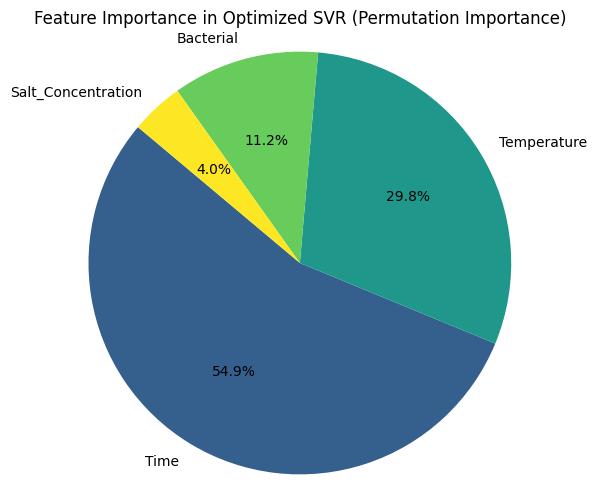

In [26]:
# Calculate permutation importance
perm_importance = permutation_importance(best_svr_model, X_train_scaled, y_train, scoring='r2')

# Convert to DataFrame for easier handling and plotting
importances_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': perm_importance.importances_mean
})

# Sort features by importance
importances_df = importances_df.sort_values(by='Importance', ascending=False)

# Plotting
colors = plt.cm.viridis(np.linspace(0.3, 1, len(importances_df)))
plt.figure(figsize=(6, 6))
plt.pie(importances_df['Importance'], labels=importances_df['Feature'], autopct='%1.1f%%', startangle=140, colors=colors)
plt.title('Feature Importance in Optimized SVR (Permutation Importance)')
plt.axis('equal')
plt.show()

### Check Correlations Between Features

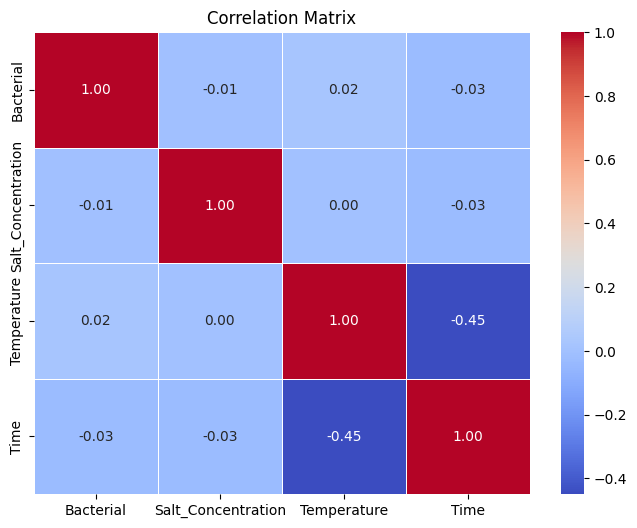

In [27]:
import seaborn as sns

# Convert X_train_scaled to a DataFrame (with appropriate feature names)
X_train_df = pd.DataFrame(X_train_scaled, columns=['Bacterial', 'Salt_Concentration', 'Temperature', 'Time'])

# Compute the correlation matrix
corr_matrix = X_train_df.corr()

# Plot the correlation heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()

### Bayesian Ridge Regression (default parameters) with polynomial degree 2



In [28]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import BayesianRidge

# Create a pipeline with PolynomialFeatures and BayesianRidge
poly_regressor = make_pipeline(PolynomialFeatures(degree=2), BayesianRidge())

blr_cv_scores = cross_val_score(poly_regressor, X_train_scaled, y_train, cv=10, scoring='r2')
print(f"CrossValidation R^2 Score: {np.mean(blr_cv_scores):.4f}")

# Fit the model with the training data
poly_regressor.fit(X_train_scaled, y_train)

# Make predictions on the test data
blr_preds = poly_regressor.predict(X_test_scaled)

blr_rmse = np.sqrt(mean_squared_error(y_test, blr_preds))
blr_r2 = r2_score(y_test, blr_preds)
print(f"Test dataset RMSE: {blr_rmse:.4f}, R^2 Score: {blr_r2:.4f}")

CrossValidation R^2 Score: 0.8358
Test dataset RMSE: 0.6324, R^2 Score: 0.8555


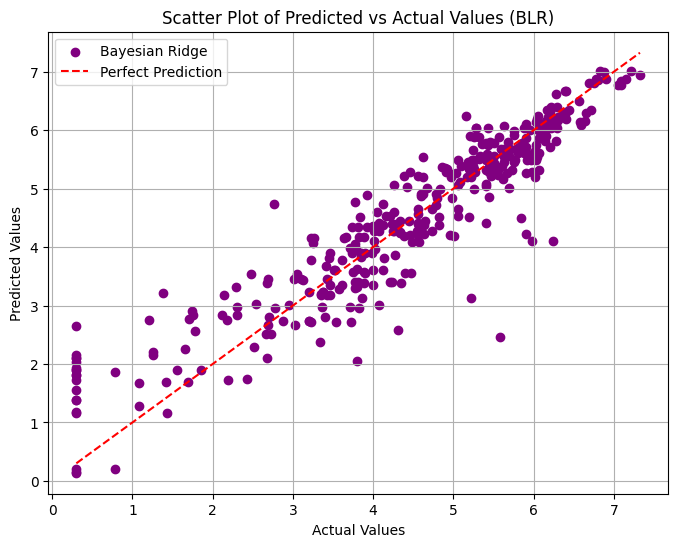

In [29]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, blr_preds, color='purple', label='Bayesian Ridge')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red', label='Perfect Prediction')
plt.title('Scatter Plot of Predicted vs Actual Values (BLR)')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.grid(True)
plt.show()

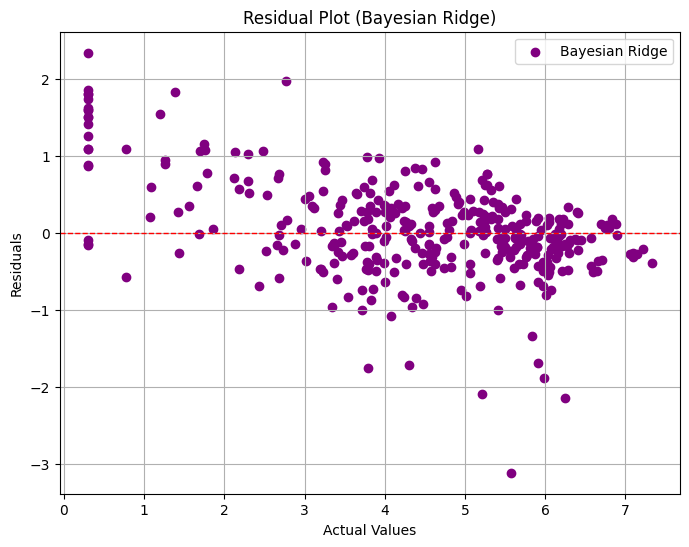

In [30]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, blr_preds - y_test, color='purple', label='Bayesian Ridge')
plt.axhline(y=0, color='red', linestyle='--', linewidth=1)
plt.title('Residual Plot (Bayesian Ridge)')
plt.xlabel('Actual Values')
plt.ylabel('Residuals')
plt.legend()
plt.grid(True)
plt.show()

<ipython-input-31-cbab072410c3>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_coeff_df['abs_Coefficient'] = filtered_coeff_df['Coefficient'].abs()


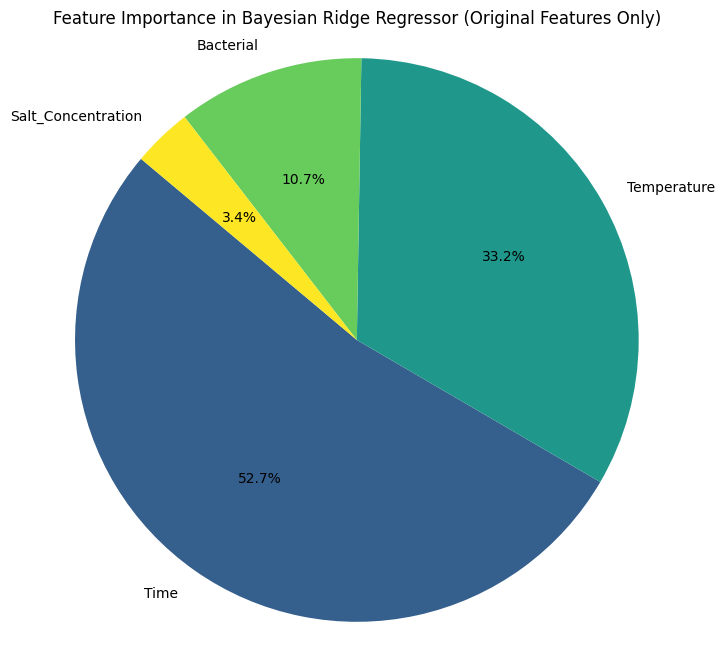

In [31]:
coefficients = poly_regressor.named_steps['bayesianridge'].coef_
poly_features = poly_regressor.named_steps['polynomialfeatures'].get_feature_names_out(input_features=X.columns)


coeff_df = pd.DataFrame({
    'Feature': poly_features,
    'Coefficient': coefficients
})

original_feature_names = ['Bacterial', 'Salt_Concentration', 'Temperature', 'Time']
filtered_coeff_df = coeff_df[coeff_df['Feature'].isin(original_feature_names)]

# Sort by absolute coefficient values to determine importance
filtered_coeff_df['abs_Coefficient'] = filtered_coeff_df['Coefficient'].abs()
filtered_coeff_df = filtered_coeff_df.sort_values(by='abs_Coefficient', ascending=False)

colors = plt.cm.viridis(np.linspace(0.3, 1, len(filtered_coeff_df)))
plt.figure(figsize=(8, 8))
plt.pie(filtered_coeff_df['abs_Coefficient'], labels=filtered_coeff_df['Feature'], autopct='%1.1f%%', startangle=140, colors=colors)
plt.title('Feature Importance in Bayesian Ridge Regressor (Original Features Only)')
plt.axis('equal')
plt.show()

### Bayesian Ridge Regression (tunning parameters)

In [32]:
# Create a pipeline with PolynomialFeatures and BayesianRidge
poly_regressor = make_pipeline(PolynomialFeatures(), BayesianRidge())

# Define the parameter grid for Polynomial Features and Bayesian Ridge
blr_params = {
    'polynomialfeatures__degree': [2, 3, 4],  # Different degrees for PolynomialFeatures
    'bayesianridge__alpha_1': [1e-6, 1e-5, 1e-4, 1e-3, 0.01],
    'bayesianridge__alpha_2': [1e-6, 1e-5, 1e-4, 1e-3, 0.01],
    'bayesianridge__lambda_1': [1e-6, 1e-5, 1e-4, 1e-3, 0.01],
    'bayesianridge__lambda_2': [1e-6, 1e-5, 1e-4, 1e-3, 0.01]
}

blr_grid_search = HalvingGridSearchCV(poly_regressor, blr_params, cv=10, scoring='r2', verbose=3)

# Fit the model
blr_grid_search.fit(X_train_scaled, y_train)

# Get the best model
best_blr_model = blr_grid_search.best_estimator_
print("Best BLR Hyperparameters:", blr_grid_search.best_params_)

Streaming output truncated to the last 5000 lines.
[CV 2/10] END bayesianridge__alpha_1=1e-06, bayesianridge__alpha_2=0.0001, bayesianridge__lambda_1=1e-06, bayesianridge__lambda_2=1e-06, polynomialfeatures__degree=3;, score=(train=0.954, test=0.864) total time=   0.0s
[CV 3/10] END bayesianridge__alpha_1=1e-06, bayesianridge__alpha_2=0.0001, bayesianridge__lambda_1=1e-06, bayesianridge__lambda_2=1e-06, polynomialfeatures__degree=3;, score=(train=0.968, test=0.612) total time=   0.0s
[CV 4/10] END bayesianridge__alpha_1=1e-06, bayesianridge__alpha_2=0.0001, bayesianridge__lambda_1=1e-06, bayesianridge__lambda_2=1e-06, polynomialfeatures__degree=3;, score=(train=0.965, test=0.681) total time=   0.0s
[CV 5/10] END bayesianridge__alpha_1=1e-06, bayesianridge__alpha_2=0.0001, bayesianridge__lambda_1=1e-06, bayesianridge__lambda_2=1e-06, polynomialfeatures__degree=3;, score=(train=0.921, test=0.636) total time=   0.0s
[CV 6/10] END bayesianridge__alpha_1=1e-06, bayesianridge__alpha_2=0.0001

In [33]:
print("Best Hyperparameters:", blr_grid_search.best_params_)

Best Hyperparameters: {'bayesianridge__alpha_1': 0.01, 'bayesianridge__alpha_2': 1e-06, 'bayesianridge__lambda_1': 1e-06, 'bayesianridge__lambda_2': 0.01, 'polynomialfeatures__degree': 3}


In [34]:
# Make predictions on the test set with the best model from GridSearchCV
blr_test_preds = best_blr_model.predict(X_test_scaled)

# Calculate performance metrics
blr_test_rmse = np.sqrt(mean_squared_error(y_test, blr_test_preds))
blr_test_r2 = r2_score(y_test, blr_test_preds)
print(f"Optimized BLR - Root Mean Squared Error: {blr_test_rmse:.4f}, R^2 Score: {blr_test_r2:.4f}")

Optimized BLR - Root Mean Squared Error: 0.5400, R^2 Score: 0.8946


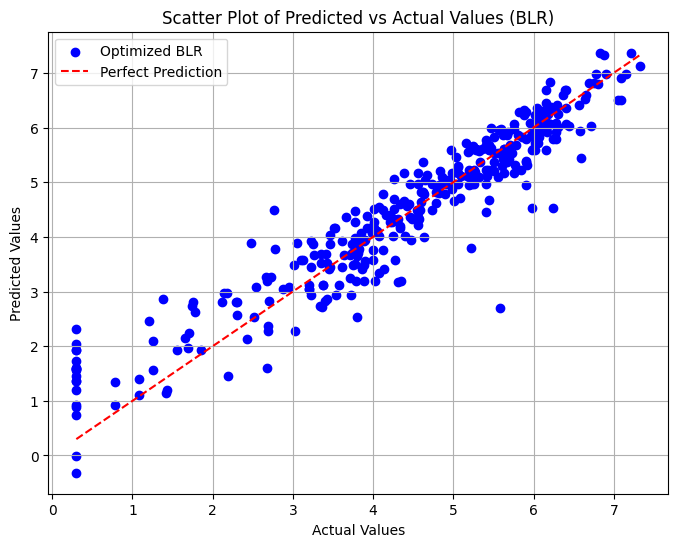

In [35]:
# Scatter plot for BLR after tunning the hyperparameters
plt.figure(figsize=(8, 6))
plt.scatter(y_test, blr_test_preds, color='blue', label='Optimized BLR')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red', label='Perfect Prediction')
plt.title('Scatter Plot of Predicted vs Actual Values (BLR)')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.grid(True)
plt.show()

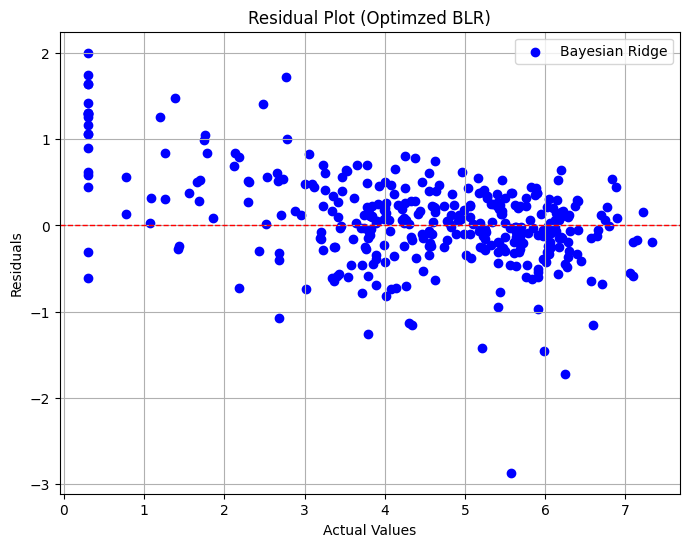

In [36]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, blr_test_preds - y_test, color='blue', label='Bayesian Ridge')
plt.axhline(y=0, color='red', linestyle='--', linewidth=1)
plt.title('Residual Plot (Optimzed BLR)')
plt.xlabel('Actual Values')
plt.ylabel('Residuals')
plt.legend()
plt.grid(True)
plt.show()

<ipython-input-37-44de90ec28b5>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_coeff_df['abs_Coefficient'] = filtered_coeff_df['Coefficient'].abs()


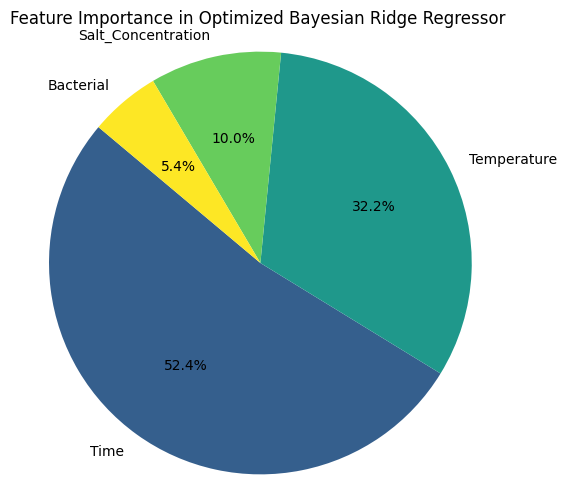

In [37]:
coefficients = best_blr_model.named_steps['bayesianridge'].coef_
poly_features = best_blr_model.named_steps['polynomialfeatures'].get_feature_names_out(input_features=X.columns)

coeff_df = pd.DataFrame({
    'Feature': poly_features,
    'Coefficient': coefficients
})

original_feature_names = ['Bacterial', 'Salt_Concentration', 'Temperature', 'Time']
filtered_coeff_df = coeff_df[coeff_df['Feature'].isin(original_feature_names)]

# Sort by absolute coefficient values to determine importance
filtered_coeff_df['abs_Coefficient'] = filtered_coeff_df['Coefficient'].abs()
filtered_coeff_df = filtered_coeff_df.sort_values(by='abs_Coefficient', ascending=False)

# Pie chart for feature importance
colors = plt.cm.viridis(np.linspace(0.3, 1, len(filtered_coeff_df)))
plt.figure(figsize=(6, 6))
plt.pie(filtered_coeff_df['abs_Coefficient'], labels=filtered_coeff_df['Feature'], autopct='%1.1f%%', startangle=140, colors=colors)
plt.title('Feature Importance in Optimized Bayesian Ridge Regressor ')
plt.axis('equal')
plt.show()

### Performance Comparison Bar Plot

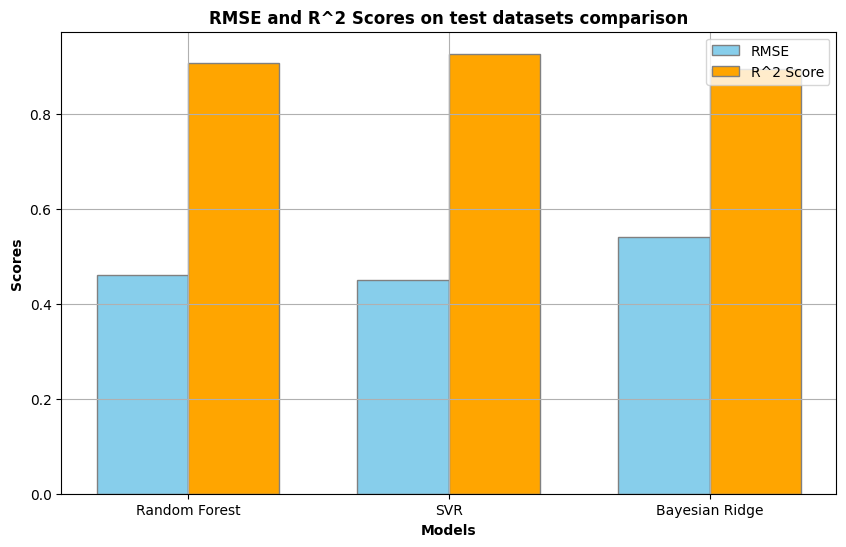

In [38]:
models = ['Random Forest', 'SVR', 'Bayesian Ridge']
rf_test_rmse = 0.4600
rf_test_r2 = 0.9068
rmse_scores = [rf_test_rmse, svr_test_rmse, blr_test_rmse]
r2_scores = [rf_test_r2, svr_test_r2, blr_test_r2]

# Plotting RMSE and R^2 scores together
fig, ax = plt.subplots(figsize=(10, 6))

bar_width = 0.35
r1 = range(len(models))
r2 = [x + bar_width for x in r1]

ax.bar(r1, rmse_scores, color='skyblue', width=bar_width, edgecolor='grey', label='RMSE')
ax.bar(r2, r2_scores, color='orange', width=bar_width, edgecolor='grey', label='R^2 Score')
ax.set_xlabel('Models', fontweight='bold')
ax.set_ylabel('Scores', fontweight='bold')
ax.set_title('RMSE and R^2 Scores on test datasets comparison', fontweight='bold')
ax.set_xticks([r + bar_width / 2 for r in range(len(models))])
ax.set_xticklabels(models)
ax.legend()

plt.grid(True)
plt.show()